In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators= 100, random_state= 10)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    lr = LinearRegression()
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.01)
    gpr1 = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(),random_state=0)
    gpr2 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=100.0, length_scale_bounds=(1e-2, 1e3))+ 
                                WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e+1)),alpha=0.0)
    gpr3 = GaussianProcessRegressor(kernel=ConstantKernel(1.0, (1e-2, 1e3)) * RBF(10, (1e-3, 1e4)),
                                n_restarts_optimizer=9)
    gpr4 = GaussianProcessRegressor(kernel=1.0 * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 10.0)))
    gpr5 = GaussianProcessRegressor(kernel=1.0 * RationalQuadratic(length_scale=1.0, alpha=0.01))
    gpr6 = GaussianProcessRegressor(kernel=1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-2, 10.0),nu=0.35))
    models = [rf,gb,lr,rr,lasso,gpr1,gpr2,gpr3,gpr4,gpr5,gpr6]
    models_names = ["RF","GB","LR","RR","LASSO","gpr1","gpr2","gpr3","gpr4","gpr5","gpr6"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        predicted_y = []
        expected_y = []
        kf = KFold(n_splits= 10) 
        # partition data
        for train_index, test_index in kf.split(X, Y):
            # specific ".loc" syntax for working with dataframes
            x_train, x_test = X.loc[train_index], X.loc[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            # create and fit classifier
            model.fit(x_train, y_train)

            # store result from classification
            predicted_y.extend(model.predict(x_test))

            # store expected result for this specific fold
            expected_y.extend(y_test)
        
        r2 = metrics.r2_score(expected_y, predicted_y)
        r2scores.append(r2)
        
        err=np.sqrt(metrics.mean_squared_error(expected_y, predicted_y))
        rmse.append(err)
        
        print(models_names[count])
        print("R2: ",r2.__str__())
        print("RMSE: ",err)
        print("---------------------------------------")
        count+=1
    
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    #plt.show()
    print(r2scores)

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
data = pd.read_csv('sisso_out_ZPE.csv', encoding='cp1252')   

In [6]:
data.columns.values

array(['Calculated', 'sqrt((B_Ra+mean_A2X))*(exp(X_G)+exp(-std_A2X))',
       'abs(((B_Rc+A_Rvdw)-mean_A2X)-((B_Rvdw+std_A2X)/exp(X_EA)))',
       '((A_EA*X_EA)/(B_Rvdw-mean_A2X))*(abs(B_Rc-mean_A2X)-abs(mean_A2B-mean_X2X))',
       'abs(abs((A_Rvdw+X_Rvdw)-(B_Rc+mean_X2X))-abs((X_Rvdw+std_A2X)-(mean_A2B+mean_X2X)))',
       '((B_Rc*B_CvM)/(B_Rc-mean_A2X))/(abs(A_Rvdw-mean_X2X)-abs(std_A2B-mean_A2B))',
       '((A_ChiA)^2*(A_MP*B_MP))*((std_B2X-mean_A2B)-abs(B_Ra-std_A2B))',
       '(abs(A_Rvdw-X_Rvdw)-abs(B_Ra-X_Rvdw))/((B_Rvdw-std_A2B)-abs(std_B2X-mean_A2B))',
       'Predicted'], dtype=object)

In [7]:
d=data.copy()
d.columns.values

array(['Calculated', 'sqrt((B_Ra+mean_A2X))*(exp(X_G)+exp(-std_A2X))',
       'abs(((B_Rc+A_Rvdw)-mean_A2X)-((B_Rvdw+std_A2X)/exp(X_EA)))',
       '((A_EA*X_EA)/(B_Rvdw-mean_A2X))*(abs(B_Rc-mean_A2X)-abs(mean_A2B-mean_X2X))',
       'abs(abs((A_Rvdw+X_Rvdw)-(B_Rc+mean_X2X))-abs((X_Rvdw+std_A2X)-(mean_A2B+mean_X2X)))',
       '((B_Rc*B_CvM)/(B_Rc-mean_A2X))/(abs(A_Rvdw-mean_X2X)-abs(std_A2B-mean_A2B))',
       '((A_ChiA)^2*(A_MP*B_MP))*((std_B2X-mean_A2B)-abs(B_Ra-std_A2B))',
       '(abs(A_Rvdw-X_Rvdw)-abs(B_Ra-X_Rvdw))/((B_Rvdw-std_A2B)-abs(std_B2X-mean_A2B))',
       'Predicted'], dtype=object)

In [8]:
columns = list(d.columns.values)

In [9]:
Y = d['Calculated'] 
X = d.drop(['Calculated','Predicted'], axis=1)

### Using CV technique

RF
R2:  0.9320940113993942
RMSE:  0.062428541415937996
---------------------------------------
GB
R2:  0.9061841755562865
RMSE:  0.07337822461305127
---------------------------------------
LR
R2:  0.9946974225954157
RMSE:  0.017445067672506778
---------------------------------------
RR
R2:  0.9928667327807745
RMSE:  0.02023361102492015
---------------------------------------
LASSO
R2:  0.9402695278708634
RMSE:  0.058550030257416785
---------------------------------------
gpr1
R2:  0.994704295166473
RMSE:  0.01743375889464129
---------------------------------------
gpr2
R2:  0.2583743295335451
RMSE:  0.20631059285047518
---------------------------------------
gpr3
R2:  0.11731001917868877
RMSE:  0.22507810424588234
---------------------------------------
gpr4
R2:  0.11731000173471573
RMSE:  0.22507810646991142
---------------------------------------
gpr5
R2:  0.6765973993641743
RMSE:  0.13623882960063943
---------------------------------------
gpr6
R2:  0.5297017923426423
RMSE:  0.16429

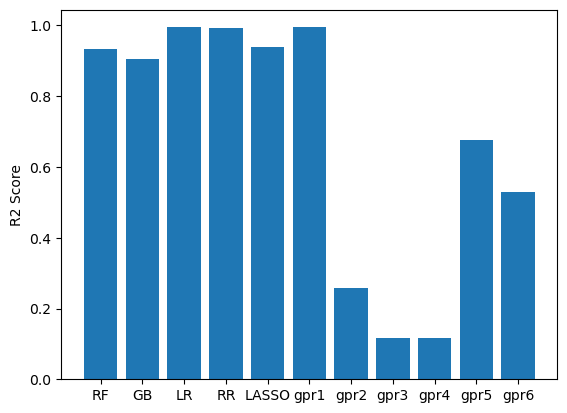

In [10]:
run_models()

## Feature selection


In [11]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=7)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

                                             Feature       Score
0     sqrt((B_Ra+mean_A2X))*(exp(X_G)+exp(-std_A2X))  953.545010
1  abs(((B_Rc+A_Rvdw)-mean_A2X)-((B_Rvdw+std_A2X)...   24.667682
2  ((A_EA*X_EA)/(B_Rvdw-mean_A2X))*(abs(B_Rc-mean...   11.114364
6  (abs(A_Rvdw-X_Rvdw)-abs(B_Ra-X_Rvdw))/((B_Rvdw...    2.734044
5  ((A_ChiA)^2*(A_MP*B_MP))*((std_B2X-mean_A2B)-a...    0.898794
3  abs(abs((A_Rvdw+X_Rvdw)-(B_Rc+mean_X2X))-abs((...    0.261438
4  ((B_Rc*B_CvM)/(B_Rc-mean_A2X))/(abs(A_Rvdw-mea...    0.047896


In [12]:
# permutation feature importance with knn for regression
models = []
count=0
kf = KFold(n_splits= 10) 
# partition data
for train_index, test_index in kf.split(X, Y):
    #model = RandomForestRegressor(n_estimators= 100, random_state= 10)
    #model = GradientBoostingRegressor(loss='quantile', alpha=0.5,
    #                            n_estimators=100, max_depth=10,
    #                            learning_rate=0.25, min_samples_leaf=9,
    #                            min_samples_split=2)
    model= Ridge(alpha=0.00001)
    # specific ".loc" syntax for working with dataframes
    x_train, x_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = Y.loc[train_index], Y.loc[test_index]

    # create and fit classifier
    model.fit(x_train, y_train)
            
    y_pred = model.predict(x_test)
    r2=sklearn.metrics.r2_score(y_test, y_pred)
    err=np.sqrt(mean_squared_error(y_test,y_pred))
    models.append(model)
    print("LR")
    print("R2: ",r2)
    print("RMSE: ",err)
    print("----------------------------------------")

LR
R2:  0.9971976878886208
RMSE:  0.010746398522427458
----------------------------------------
LR
R2:  0.9988520828066514
RMSE:  0.011576787786509356
----------------------------------------
LR
R2:  0.9901354086010912
RMSE:  0.01985209863439012
----------------------------------------
LR
R2:  0.9754830355622548
RMSE:  0.023265682244975276
----------------------------------------
LR
R2:  0.9983233417278616
RMSE:  0.010257257435322343
----------------------------------------
LR
R2:  0.9795345179780267
RMSE:  0.01734985019269067
----------------------------------------
LR
R2:  0.9902566927785336
RMSE:  0.02091851054260487
----------------------------------------
LR
R2:  0.9912928149954932
RMSE:  0.021234387275096835
----------------------------------------
LR
R2:  0.9904192980557014
RMSE:  0.016712010738102863
----------------------------------------
LR
R2:  0.9852888731440793
RMSE:  0.016846791005640696
----------------------------------------


GB
R2:  0.9955398849080996
RMSE:  0.01599934424641435
----------------------------------------


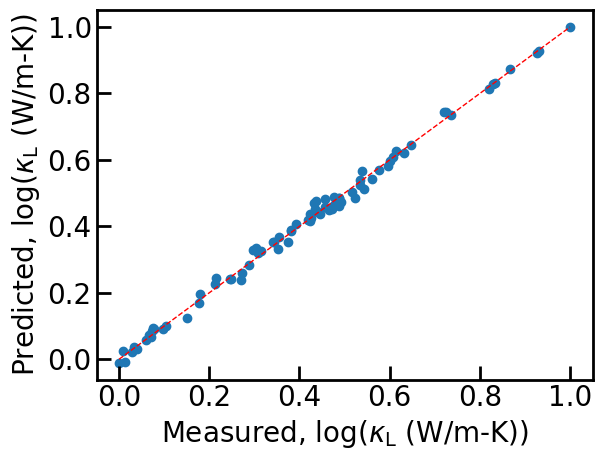

In [14]:
model = models[1]
predicted = model.predict(X)
r2=sklearn.metrics.r2_score(Y, predicted)
err=np.sqrt(mean_squared_error(Y,predicted))
print("GB")
print("R2: ",r2)
print("RMSE: ",err)
print("----------------------------------------")
fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', lw=1)
#for i in range(len(Y_test)):
#    plt.annotate(text[i], (Y_test[i], predicted[i]))
ax.set_xlabel("Measured, log($\kappa_\mathrm{L}$ (W/m-K))",fontsize= 20)
ax.set_ylabel("Predicted, log($\kappa_\mathrm{L}$ (W/m-K))",fontsize= 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.tick_params(direction='in', length=10, width=2)
for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)
plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
plt.show()

Feature: 0, Score: 0.08587
Feature: 1, Score: 0.00421
Feature: 2, Score: 0.00145
Feature: 3, Score: 0.00156
Feature: 4, Score: 0.00052
Feature: 5, Score: 0.00045
Feature: 6, Score: 0.00025


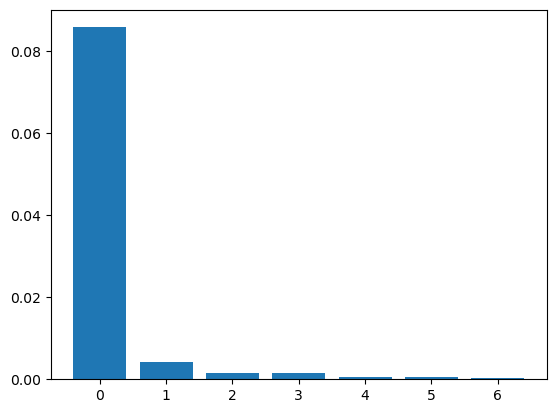

In [15]:
# fit the model
feature_scores=[]
model.fit(X, Y)
# perform permutation importance
results = permutation_importance(model, X, Y, scoring='neg_mean_squared_error')
# get importance
importance = results.importances_mean

# summarize feature importance
for i,v in enumerate(importance):
    feature_scores.append(v)
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [16]:
featureNames = X.columns
dfscores = pd.DataFrame(feature_scores)
dfcolumns = pd.DataFrame(featureNames)
#concat two dataframes for better visualization 
featureImportance = pd.concat([dfcolumns,dfscores],axis=1)
featureImportance.columns = ['Feature','Score']  #naming the dataframe columns
print(featureImportance.nlargest(10,'Score'))  #print 10 best features

                                             Feature     Score
0     sqrt((B_Ra+mean_A2X))*(exp(X_G)+exp(-std_A2X))  0.085868
1  abs(((B_Rc+A_Rvdw)-mean_A2X)-((B_Rvdw+std_A2X)...  0.004209
3  abs(abs((A_Rvdw+X_Rvdw)-(B_Rc+mean_X2X))-abs((...  0.001564
2  ((A_EA*X_EA)/(B_Rvdw-mean_A2X))*(abs(B_Rc-mean...  0.001452
4  ((B_Rc*B_CvM)/(B_Rc-mean_A2X))/(abs(A_Rvdw-mea...  0.000519
5  ((A_ChiA)^2*(A_MP*B_MP))*((std_B2X-mean_A2B)-a...  0.000455
6  (abs(A_Rvdw-X_Rvdw)-abs(B_Ra-X_Rvdw))/((B_Rvdw...  0.000252


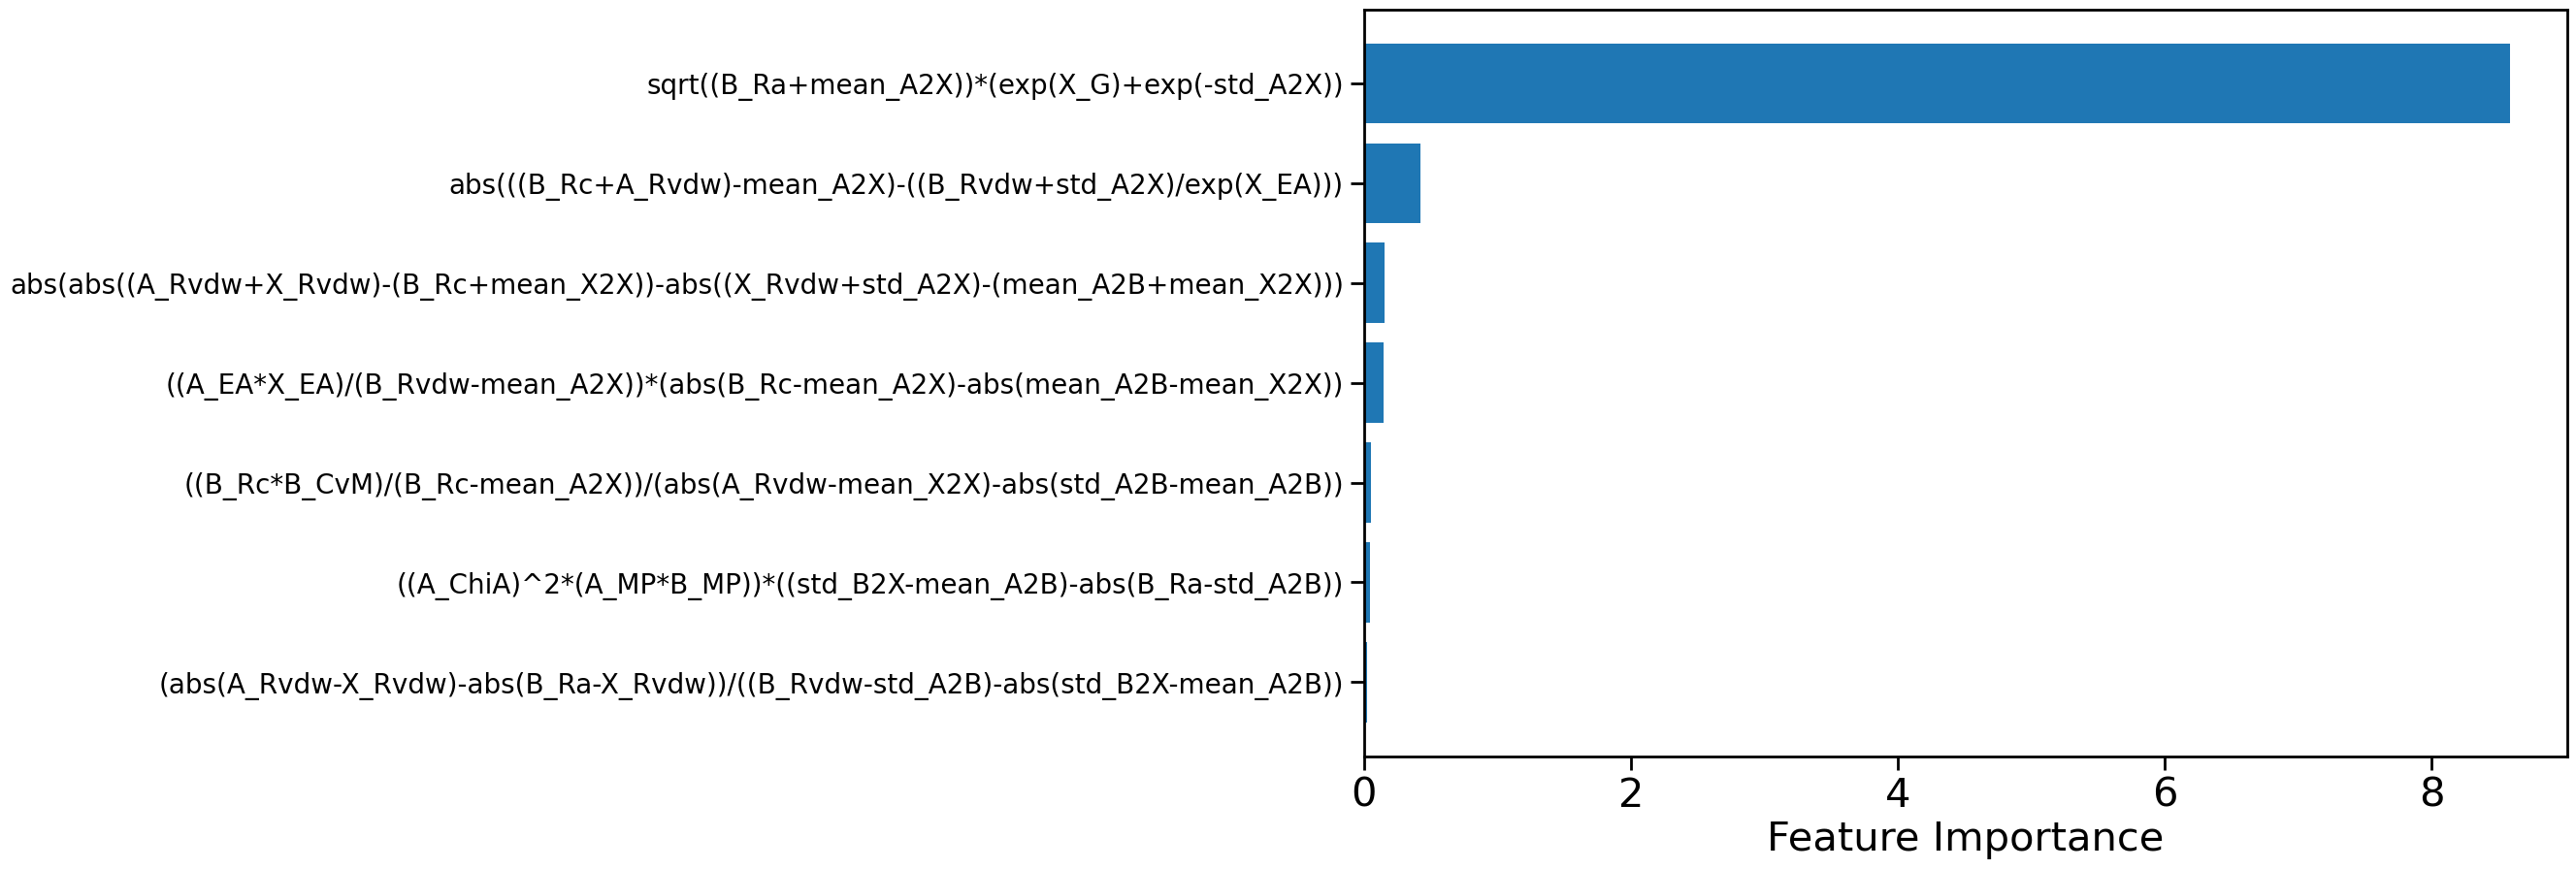

In [17]:
features = featureImportance.nlargest(10,'Score')['Feature']
Score = featureImportance.nlargest(10,'Score')['Score']*100
# Figure Size
plt.rcdefaults()
fig, ax = plt.subplots(figsize =(16, 10))

#y_pos = np.arange(len(features))
importance = Score
ax.barh(features, importance, align='center')

for axis in ['top','bottom','left','right']:
  ax.spines[axis].set_linewidth(2)

# Remove x, y Ticks
#ax.xaxis.set_ticks_position('none')
#ax.yaxis.set_ticks_position('none')

ax.tick_params(direction='out', length=10, width=2)


# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 5)
 
ax.set_yticklabels(features, fontsize= 20)
plt.xticks(fontsize=30)
#ax.set_xticklabels(Score, fontsize= 20)
# Add x, y gridlines
#ax.grid(b = True, color ='grey',
#        linestyle ='-.', linewidth = 0.5,
 #       alpha = 0.2)

# Show top values
ax.invert_yaxis()


# Add annotation to bars
#for i in ax.patches:
 #   plt.text(i.get_width()+0.2, i.get_y()+0.5,
 #            str(round((i.get_width()), 2)),
#             fontsize = 15, fontweight ='bold',
#             color ='black') 
 
# Add Plot Title
#ax.set_title('Top 10 features',loc ='center', fontsize = 30)
''' 
# Add Text watermark
fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize = 12,
         color ='grey', ha ='right', va ='bottom',
         alpha = 0.7)'''
#plot save
ax.set_xlabel('Feature Importance', fontsize = 30)
plt.savefig('imp.eps', format='eps')
# Show Plot
plt.show()

In [ ]:
#from pysisso.sklearn import SISSORegressor
#CLEAN_RUN_DIR = False
# Define the regressor, fit the data and predict
#sisso_regressor = SISSORegressor(
#    rung=2,
#    opset="(+)(-)(*)(/)(exp)(exp-)(^-1)(^2)(^3)(sqrt)(cbrt)(log)(|-|)(scd)(^6)(sin)(cos)",
#    desc_dim=10,
    #dimclass=(1:3)(4:9)(10:12)(13:15)(16:21)(21:24)(25:27)(28:30)(35:35)(36:36)(37:37)(38:38)(39:39)(40:40),
#    clean_run_dir=CLEAN_RUN_DIR,
#)
#X = X.reshape(-1, 1)  # only one feature, X is initially defined as 1D, sklearn needs 2D
#sisso_regressor.fit(X, Y)